# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

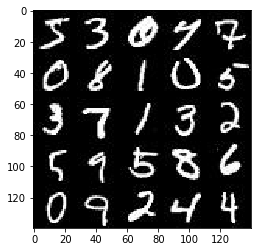

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

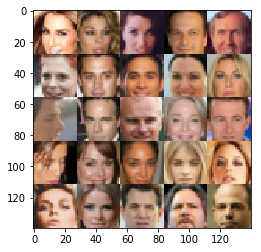

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\moono.song\\AppData\\Local\\conda\\conda\\envs\\tensorflow-gpu\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\moono.song\\AppData\\Local\\conda\\conda\\envs\\tensorflow-gpu\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\moono.song\\AppData\\Local\\conda\\conda\\envs\\tensorflow-gpu\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\moono.song\\AppData\\Local\\conda\\conda\\envs\\tensorflow-gpu\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\moono.song\\AppData

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # input is 28x28x1 or 28x28x3
        
        # try different weight initializer
        # w_init = tf.contrib.layers.variance_scaling_initializer()
        w_init = tf.contrib.layers.xavier_initializer()
        
        # for leaky ReLU
        alpha = 0.2
        
        # make 14x14x64
        filters = 64
        x1 = tf.layers.conv2d(inputs=images, filters=filters, kernel_size=5, strides=2, padding='same', activation=None, kernel_initializer=w_init)
        x1 = tf.maximum(alpha * x1, x1)
        
        # make 7x7x128
        filters = filters * 2
        x2 = tf.layers.conv2d(inputs=x1, filters=filters, kernel_size=5, strides=2, padding='same', activation=None, kernel_initializer=w_init)
        x2 = tf.layers.batch_normalization(inputs=x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # make 4x4x256
        filters = filters * 2
        x3 = tf.layers.conv2d(inputs=x2, filters=filters, kernel_size=5, strides=2, padding='same', activation=None, kernel_initializer=w_init)
        x3 = tf.layers.batch_normalization(inputs=x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # flatten the layer
        flattend_layer = tf.reshape(tensor=x3, shape=[-1, 4*4*filters])
        logits = tf.layers.dense(inputs=flattend_layer, units=1, activation=None, use_bias=True, kernel_initializer=w_init)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = False if is_train == True else True
    with tf.variable_scope('generator', reuse=reuse):
        # input is z_dim
        
        # try different weight initializer
        # w_init = tf.contrib.layers.variance_scaling_initializer()
        w_init = tf.contrib.layers.xavier_initializer()
        
        # for leaky ReLU
        alpha = 0.2
        
        # 1. Fully connected layer (make 3x3x512) & reshape to prepare first layer
        feature_map_size = 512
        x1 = tf.layers.dense(inputs=z, units=3*3*feature_map_size, activation=None, use_bias=True, kernel_initializer=w_init)
        x1 = tf.reshape(tensor=x1, shape=[-1, 3, 3, feature_map_size])
        x1 = tf.layers.batch_normalization(inputs=x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 2. deconvolutional layer (make 7x7x256)
        # kernel size & padding should be 3 & 'valid' to make output layer it 7x7x256
        # this is neccessary to make final layer 28x28x?
        feature_map_size = feature_map_size // 2
        x2 = tf.layers.conv2d_transpose(inputs=x1, filters=feature_map_size, kernel_size=3, strides=2, padding='valid', activation=None, kernel_initializer=w_init)
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 3. deconvolutional layer (make 14x14x128)
        feature_map_size = feature_map_size // 2
        x3 = tf.layers.conv2d_transpose(inputs=x2, filters=feature_map_size, kernel_size=5, strides=2, padding='same', activation=None, kernel_initializer=w_init)
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 4. Output layer, 28x28x1 or 28x28x3
        logits = tf.layers.conv2d_transpose(inputs=x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same', activation=None, kernel_initializer=w_init)
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # build each model
    g_model = generator(input_z, out_channel_dim=out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # loss compuation graph
    smooth = 0.1
    d_real_label = tf.ones_like(d_logits_real) * (1 - smooth)
    d_fake_label = tf.zeros_like(d_logits_real)
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_real_label) )
    d_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_fake_label) )
    d_loss = d_loss_real + d_loss_fake
    
    g_label = tf.ones_like(d_logits_fake)
    g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_label) )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # get each trainable variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimaization graph
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data ==> [number_of_images, width, height, channel]
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    # get input place holders
    input_real, input_z, input_learning_rate = model_inputs(image_width=data_shape[1], 
                                                            image_height=data_shape[2], 
                                                            image_channels=data_shape[3], 
                                                            z_dim=z_dim)
    
    # build model
    d_loss, g_loss = model_loss(input_real=input_real, input_z=input_z, out_channel_dim=data_shape[3])
    
    # build optimizer
    d_train_opt, g_train_opt = model_opt(d_loss=d_loss, g_loss=g_loss, learning_rate=input_learning_rate, beta1=beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps = steps + 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:        
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4870... Generator Loss: 2.6445
Epoch 1/2... Discriminator Loss: 0.4664... Generator Loss: 2.4379
Epoch 1/2... Discriminator Loss: 0.5553... Generator Loss: 3.8138
Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 1.4588... Generator Loss: 5.3254
Epoch 1/2... Discriminator Loss: 0.6192... Generator Loss: 2.4918
Epoch 1/2... Discriminator Loss: 0.6243... Generator Loss: 2.4426
Epoch 1/2... Discriminator Loss: 0.6043... Generator Loss: 1.9920
Epoch 1/2... Discriminator Loss: 0.7360... Generator Loss: 2.5880
Epoch 1/2... Discriminator Loss: 0.8428... Generator Loss: 1.2016


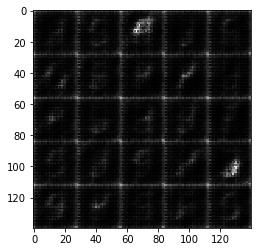

Epoch 1/2... Discriminator Loss: 0.5509... Generator Loss: 2.0397
Epoch 1/2... Discriminator Loss: 0.5439... Generator Loss: 2.2287
Epoch 1/2... Discriminator Loss: 0.5175... Generator Loss: 2.8413
Epoch 1/2... Discriminator Loss: 0.6212... Generator Loss: 3.2075
Epoch 1/2... Discriminator Loss: 0.6198... Generator Loss: 1.9466
Epoch 1/2... Discriminator Loss: 0.6692... Generator Loss: 1.6518
Epoch 1/2... Discriminator Loss: 0.5856... Generator Loss: 1.7797
Epoch 1/2... Discriminator Loss: 0.5783... Generator Loss: 2.0224
Epoch 1/2... Discriminator Loss: 0.5210... Generator Loss: 2.0148
Epoch 1/2... Discriminator Loss: 0.6720... Generator Loss: 4.5622


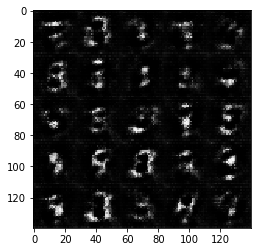

Epoch 1/2... Discriminator Loss: 0.4775... Generator Loss: 3.1017
Epoch 1/2... Discriminator Loss: 0.4237... Generator Loss: 2.7477
Epoch 1/2... Discriminator Loss: 0.4201... Generator Loss: 2.8187
Epoch 1/2... Discriminator Loss: 0.5388... Generator Loss: 2.2759
Epoch 1/2... Discriminator Loss: 1.7073... Generator Loss: 1.1480
Epoch 1/2... Discriminator Loss: 0.6164... Generator Loss: 3.7158
Epoch 1/2... Discriminator Loss: 0.5578... Generator Loss: 3.3478
Epoch 1/2... Discriminator Loss: 0.4902... Generator Loss: 2.7231
Epoch 1/2... Discriminator Loss: 0.5991... Generator Loss: 2.3951
Epoch 1/2... Discriminator Loss: 0.9537... Generator Loss: 1.6922


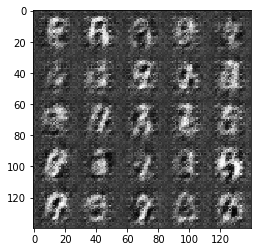

Epoch 1/2... Discriminator Loss: 0.9371... Generator Loss: 1.1357
Epoch 1/2... Discriminator Loss: 1.0541... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 0.5481... Generator Loss: 2.5169
Epoch 1/2... Discriminator Loss: 0.5508... Generator Loss: 2.5427
Epoch 1/2... Discriminator Loss: 0.5292... Generator Loss: 2.4131
Epoch 1/2... Discriminator Loss: 0.6079... Generator Loss: 2.8275
Epoch 1/2... Discriminator Loss: 0.5010... Generator Loss: 2.2373
Epoch 1/2... Discriminator Loss: 0.6645... Generator Loss: 4.0374
Epoch 1/2... Discriminator Loss: 0.6410... Generator Loss: 1.9340
Epoch 1/2... Discriminator Loss: 0.6393... Generator Loss: 1.5081


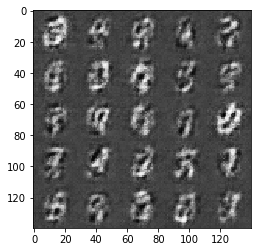

Epoch 1/2... Discriminator Loss: 0.5205... Generator Loss: 2.9057
Epoch 1/2... Discriminator Loss: 0.5989... Generator Loss: 3.1489
Epoch 1/2... Discriminator Loss: 0.5224... Generator Loss: 2.1370
Epoch 1/2... Discriminator Loss: 0.4798... Generator Loss: 2.3549
Epoch 1/2... Discriminator Loss: 0.4220... Generator Loss: 3.2265
Epoch 1/2... Discriminator Loss: 0.4733... Generator Loss: 2.4393
Epoch 1/2... Discriminator Loss: 0.4679... Generator Loss: 2.4633
Epoch 1/2... Discriminator Loss: 0.4963... Generator Loss: 2.3203
Epoch 1/2... Discriminator Loss: 0.4737... Generator Loss: 2.4169
Epoch 1/2... Discriminator Loss: 0.4290... Generator Loss: 2.9488


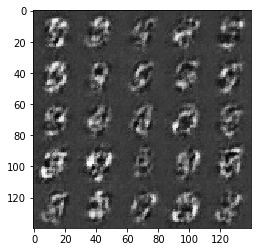

Epoch 1/2... Discriminator Loss: 0.4627... Generator Loss: 2.7123
Epoch 1/2... Discriminator Loss: 0.5394... Generator Loss: 2.0371
Epoch 1/2... Discriminator Loss: 0.5813... Generator Loss: 3.6957
Epoch 1/2... Discriminator Loss: 0.4188... Generator Loss: 3.1050
Epoch 1/2... Discriminator Loss: 0.4780... Generator Loss: 3.4603
Epoch 1/2... Discriminator Loss: 0.7233... Generator Loss: 1.4541
Epoch 1/2... Discriminator Loss: 0.5153... Generator Loss: 2.0372
Epoch 1/2... Discriminator Loss: 0.5256... Generator Loss: 2.0019
Epoch 1/2... Discriminator Loss: 0.4634... Generator Loss: 2.4137
Epoch 1/2... Discriminator Loss: 0.4169... Generator Loss: 3.0523


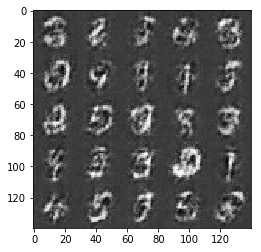

Epoch 1/2... Discriminator Loss: 0.4709... Generator Loss: 2.2634
Epoch 1/2... Discriminator Loss: 0.8510... Generator Loss: 4.7847
Epoch 1/2... Discriminator Loss: 0.4643... Generator Loss: 2.5590
Epoch 1/2... Discriminator Loss: 0.5004... Generator Loss: 2.1087
Epoch 1/2... Discriminator Loss: 0.5297... Generator Loss: 1.9313
Epoch 1/2... Discriminator Loss: 0.4308... Generator Loss: 2.7197
Epoch 1/2... Discriminator Loss: 0.5313... Generator Loss: 3.1472
Epoch 1/2... Discriminator Loss: 0.4998... Generator Loss: 2.2042
Epoch 1/2... Discriminator Loss: 0.4233... Generator Loss: 3.3485
Epoch 1/2... Discriminator Loss: 0.3899... Generator Loss: 3.1206


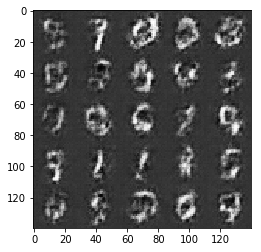

Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 1.0387
Epoch 1/2... Discriminator Loss: 0.4524... Generator Loss: 2.5891
Epoch 1/2... Discriminator Loss: 0.4309... Generator Loss: 3.6025
Epoch 1/2... Discriminator Loss: 0.4419... Generator Loss: 2.6890
Epoch 1/2... Discriminator Loss: 0.4470... Generator Loss: 2.6399
Epoch 1/2... Discriminator Loss: 0.4270... Generator Loss: 2.7606
Epoch 1/2... Discriminator Loss: 0.4924... Generator Loss: 2.0051
Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 1.5663
Epoch 1/2... Discriminator Loss: 0.4245... Generator Loss: 2.8731
Epoch 1/2... Discriminator Loss: 0.5266... Generator Loss: 2.0108


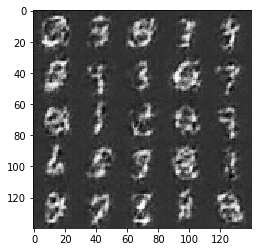

Epoch 1/2... Discriminator Loss: 0.4083... Generator Loss: 2.9105
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 2.8959
Epoch 1/2... Discriminator Loss: 0.4095... Generator Loss: 3.8242
Epoch 1/2... Discriminator Loss: 0.3943... Generator Loss: 3.4605
Epoch 1/2... Discriminator Loss: 0.4415... Generator Loss: 4.3361
Epoch 1/2... Discriminator Loss: 1.2798... Generator Loss: 0.8714
Epoch 1/2... Discriminator Loss: 0.4583... Generator Loss: 3.2903
Epoch 1/2... Discriminator Loss: 0.4448... Generator Loss: 2.4375
Epoch 1/2... Discriminator Loss: 0.4550... Generator Loss: 2.6804
Epoch 1/2... Discriminator Loss: 0.3971... Generator Loss: 3.1163


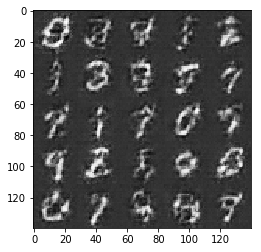

Epoch 1/2... Discriminator Loss: 0.4516... Generator Loss: 2.3475
Epoch 1/2... Discriminator Loss: 0.3794... Generator Loss: 3.9003
Epoch 1/2... Discriminator Loss: 0.4597... Generator Loss: 2.4230
Epoch 2/2... Discriminator Loss: 0.3611... Generator Loss: 3.9252
Epoch 2/2... Discriminator Loss: 0.3772... Generator Loss: 3.8234
Epoch 2/2... Discriminator Loss: 0.3720... Generator Loss: 3.6065
Epoch 2/2... Discriminator Loss: 0.3872... Generator Loss: 3.3940
Epoch 2/2... Discriminator Loss: 0.4118... Generator Loss: 2.7958
Epoch 2/2... Discriminator Loss: 0.4109... Generator Loss: 3.4645
Epoch 2/2... Discriminator Loss: 0.4509... Generator Loss: 2.4112


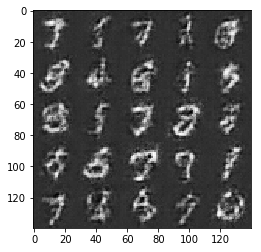

Epoch 2/2... Discriminator Loss: 0.3864... Generator Loss: 3.3547
Epoch 2/2... Discriminator Loss: 0.3751... Generator Loss: 3.6654
Epoch 2/2... Discriminator Loss: 0.4240... Generator Loss: 2.8999
Epoch 2/2... Discriminator Loss: 0.3825... Generator Loss: 3.5037
Epoch 2/2... Discriminator Loss: 0.3871... Generator Loss: 4.4196
Epoch 2/2... Discriminator Loss: 0.4152... Generator Loss: 4.6297
Epoch 2/2... Discriminator Loss: 5.5379... Generator Loss: 0.0379
Epoch 2/2... Discriminator Loss: 0.4492... Generator Loss: 2.7332
Epoch 2/2... Discriminator Loss: 0.5192... Generator Loss: 2.0343
Epoch 2/2... Discriminator Loss: 0.4399... Generator Loss: 2.5278


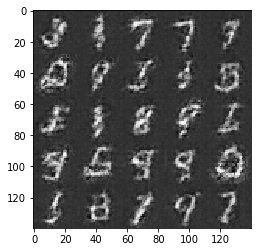

Epoch 2/2... Discriminator Loss: 0.3876... Generator Loss: 3.4224
Epoch 2/2... Discriminator Loss: 0.3975... Generator Loss: 2.9775
Epoch 2/2... Discriminator Loss: 0.3935... Generator Loss: 3.3799
Epoch 2/2... Discriminator Loss: 0.3691... Generator Loss: 3.7520
Epoch 2/2... Discriminator Loss: 0.4931... Generator Loss: 2.1625
Epoch 2/2... Discriminator Loss: 0.4118... Generator Loss: 2.7705
Epoch 2/2... Discriminator Loss: 0.3969... Generator Loss: 3.0851
Epoch 2/2... Discriminator Loss: 0.4292... Generator Loss: 2.5427
Epoch 2/2... Discriminator Loss: 0.3596... Generator Loss: 4.2601
Epoch 2/2... Discriminator Loss: 0.4711... Generator Loss: 2.2259


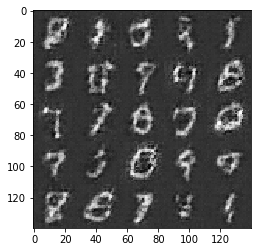

Epoch 2/2... Discriminator Loss: 0.3529... Generator Loss: 4.0578
Epoch 2/2... Discriminator Loss: 0.4136... Generator Loss: 2.7260
Epoch 2/2... Discriminator Loss: 0.4279... Generator Loss: 2.6236
Epoch 2/2... Discriminator Loss: 0.3846... Generator Loss: 3.2791
Epoch 2/2... Discriminator Loss: 0.9829... Generator Loss: 2.5809
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.6676
Epoch 2/2... Discriminator Loss: 0.7684... Generator Loss: 1.3470
Epoch 2/2... Discriminator Loss: 0.5764... Generator Loss: 1.8324
Epoch 2/2... Discriminator Loss: 0.4916... Generator Loss: 2.4682
Epoch 2/2... Discriminator Loss: 0.4722... Generator Loss: 2.3473


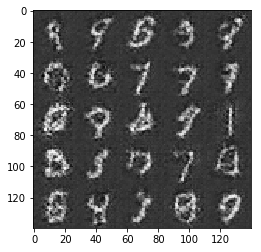

Epoch 2/2... Discriminator Loss: 0.4472... Generator Loss: 2.4640
Epoch 2/2... Discriminator Loss: 0.4079... Generator Loss: 2.9581
Epoch 2/2... Discriminator Loss: 0.4575... Generator Loss: 2.3116
Epoch 2/2... Discriminator Loss: 0.3697... Generator Loss: 4.0845
Epoch 2/2... Discriminator Loss: 0.4830... Generator Loss: 2.1764
Epoch 2/2... Discriminator Loss: 0.3720... Generator Loss: 3.4541
Epoch 2/2... Discriminator Loss: 0.3740... Generator Loss: 3.4660
Epoch 2/2... Discriminator Loss: 0.4015... Generator Loss: 3.8273
Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 2.7931
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 0.8767


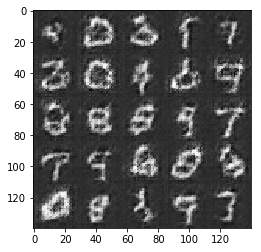

Epoch 2/2... Discriminator Loss: 0.5716... Generator Loss: 1.8428
Epoch 2/2... Discriminator Loss: 0.5153... Generator Loss: 1.9311
Epoch 2/2... Discriminator Loss: 0.4709... Generator Loss: 2.1877
Epoch 2/2... Discriminator Loss: 0.4019... Generator Loss: 3.1220
Epoch 2/2... Discriminator Loss: 0.4673... Generator Loss: 2.2535
Epoch 2/2... Discriminator Loss: 0.3939... Generator Loss: 3.2273
Epoch 2/2... Discriminator Loss: 0.3955... Generator Loss: 2.8915
Epoch 2/2... Discriminator Loss: 0.4000... Generator Loss: 2.9256
Epoch 2/2... Discriminator Loss: 0.3995... Generator Loss: 3.0357
Epoch 2/2... Discriminator Loss: 0.3877... Generator Loss: 3.8646


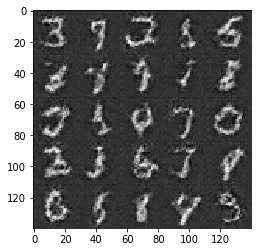

Epoch 2/2... Discriminator Loss: 0.3739... Generator Loss: 3.4249
Epoch 2/2... Discriminator Loss: 0.3726... Generator Loss: 3.5245
Epoch 2/2... Discriminator Loss: 0.3537... Generator Loss: 4.7075
Epoch 2/2... Discriminator Loss: 0.3524... Generator Loss: 4.3812
Epoch 2/2... Discriminator Loss: 0.3503... Generator Loss: 4.2391
Epoch 2/2... Discriminator Loss: 0.3627... Generator Loss: 3.6948
Epoch 2/2... Discriminator Loss: 0.4096... Generator Loss: 2.9557
Epoch 2/2... Discriminator Loss: 0.3775... Generator Loss: 3.2483
Epoch 2/2... Discriminator Loss: 0.3700... Generator Loss: 4.0102
Epoch 2/2... Discriminator Loss: 0.3676... Generator Loss: 3.7101


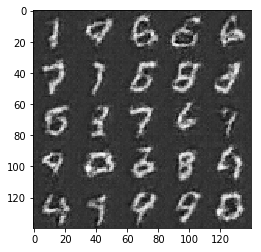

Epoch 2/2... Discriminator Loss: 0.5098... Generator Loss: 1.9369
Epoch 2/2... Discriminator Loss: 2.8097... Generator Loss: 4.0718
Epoch 2/2... Discriminator Loss: 0.8862... Generator Loss: 1.2640
Epoch 2/2... Discriminator Loss: 0.8232... Generator Loss: 1.1343
Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 1.7093
Epoch 2/2... Discriminator Loss: 0.5873... Generator Loss: 1.6945
Epoch 2/2... Discriminator Loss: 0.4740... Generator Loss: 2.5091
Epoch 2/2... Discriminator Loss: 0.4812... Generator Loss: 2.1874
Epoch 2/2... Discriminator Loss: 0.4422... Generator Loss: 3.4794
Epoch 2/2... Discriminator Loss: 0.4672... Generator Loss: 2.2386


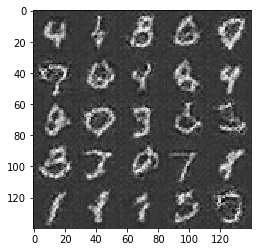

Epoch 2/2... Discriminator Loss: 0.3508... Generator Loss: 4.2164
Epoch 2/2... Discriminator Loss: 0.6037... Generator Loss: 1.7838
Epoch 2/2... Discriminator Loss: 0.4064... Generator Loss: 3.1607
Epoch 2/2... Discriminator Loss: 0.3935... Generator Loss: 3.0398
Epoch 2/2... Discriminator Loss: 0.3988... Generator Loss: 3.0501
Epoch 2/2... Discriminator Loss: 0.3886... Generator Loss: 3.2143
Epoch 2/2... Discriminator Loss: 0.4211... Generator Loss: 2.6850
Epoch 2/2... Discriminator Loss: 0.4404... Generator Loss: 2.5475
Epoch 2/2... Discriminator Loss: 0.4065... Generator Loss: 3.4243
Epoch 2/2... Discriminator Loss: 0.4116... Generator Loss: 2.9885


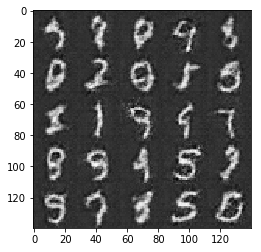

Epoch 2/2... Discriminator Loss: 0.4629... Generator Loss: 2.2972
Epoch 2/2... Discriminator Loss: 0.5344... Generator Loss: 1.9002
Epoch 2/2... Discriminator Loss: 0.3638... Generator Loss: 3.7597
Epoch 2/2... Discriminator Loss: 0.3784... Generator Loss: 3.4818
Epoch 2/2... Discriminator Loss: 0.3822... Generator Loss: 4.1331
Epoch 2/2... Discriminator Loss: 0.4316... Generator Loss: 2.5712
Epoch 2/2... Discriminator Loss: 0.3521... Generator Loss: 4.0565


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 1.7797
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 2.2283
Epoch 1/1... Discriminator Loss: 0.4880... Generator Loss: 2.8692
Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 4.5757
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 3.0219
Epoch 1/1... Discriminator Loss: 2.1092... Generator Loss: 9.8379
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 2.1029
Epoch 1/1... Discriminator Loss: 0.5824... Generator Loss: 2.3930
Epoch 1/1... Discriminator Loss: 0.6068... Generator Loss: 4.5999
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 2.3181


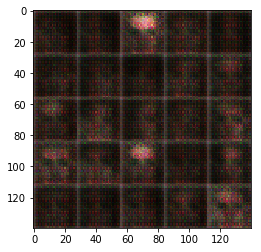

Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 2.7329
Epoch 1/1... Discriminator Loss: 0.4346... Generator Loss: 2.9562
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 2.9295
Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 2.7413
Epoch 1/1... Discriminator Loss: 0.4288... Generator Loss: 2.8891
Epoch 1/1... Discriminator Loss: 0.4010... Generator Loss: 3.2804
Epoch 1/1... Discriminator Loss: 0.4515... Generator Loss: 5.4024
Epoch 1/1... Discriminator Loss: 0.5847... Generator Loss: 1.8627
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 1.7087
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 3.6943


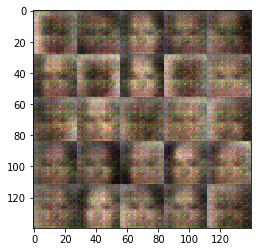

Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 1.9538
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 3.8076
Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 1.5950
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 2.5355
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 2.6694
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 6.2511
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.0755
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 1.6262
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.8388


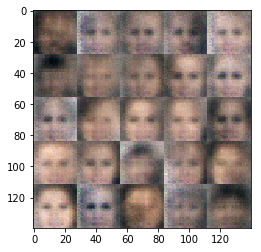

Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.7355
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 10.2613
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 1.7252
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 2.2240
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 4.9448
Epoch 1/1... Discriminator Loss: 0.4797... Generator Loss: 3.0082
Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 1.9130
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.5067


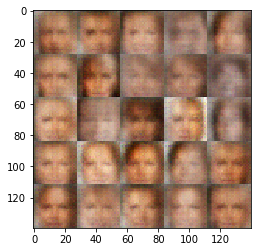

Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 2.1608
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 0.4365... Generator Loss: 3.1100
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 2.9587
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 1.8793
Epoch 1/1... Discriminator Loss: 0.5454... Generator Loss: 1.9782
Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 2.0273
Epoch 1/1... Discriminator Loss: 4.0914... Generator Loss: 10.9452
Epoch 1/1... Discriminator Loss: 0.5278... Generator Loss: 2.5125
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 2.6330


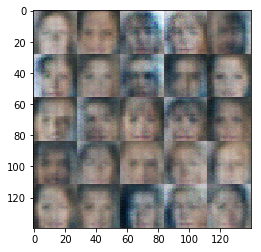

Epoch 1/1... Discriminator Loss: 1.7867... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 8.4931
Epoch 1/1... Discriminator Loss: 0.5040... Generator Loss: 3.2446
Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 3.3625
Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 2.1073
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 2.0931
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 5.6449
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 5.2550
Epoch 1/1... Discriminator Loss: 0.4317... Generator Loss: 3.4059
Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 2.4614


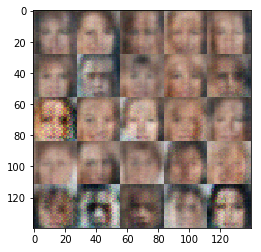

Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 4.1997
Epoch 1/1... Discriminator Loss: 0.4717... Generator Loss: 4.0603
Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 5.1275
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 3.5835
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 5.0430
Epoch 1/1... Discriminator Loss: 0.4144... Generator Loss: 3.5200
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 3.3055
Epoch 1/1... Discriminator Loss: 0.3665... Generator Loss: 5.3146
Epoch 1/1... Discriminator Loss: 0.3639... Generator Loss: 5.3041
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 4.3387


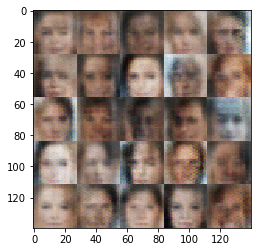

Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 2.6397
Epoch 1/1... Discriminator Loss: 0.3737... Generator Loss: 6.6587
Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 6.3426
Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 4.1916
Epoch 1/1... Discriminator Loss: 0.4721... Generator Loss: 2.8857
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.1120
Epoch 1/1... Discriminator Loss: 0.3701... Generator Loss: 4.5068
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.4256
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.1763
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 2.8200


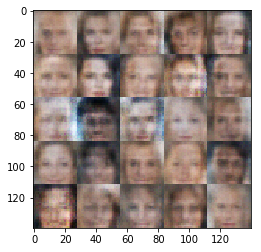

Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 2.1320
Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 5.1436
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 2.4233
Epoch 1/1... Discriminator Loss: 0.4425... Generator Loss: 5.9517
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 1.5223
Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 4.3401
Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 5.9656
Epoch 1/1... Discriminator Loss: 0.3660... Generator Loss: 4.6544
Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 5.1226
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 6.0082


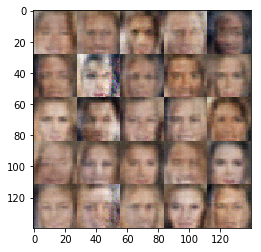

Epoch 1/1... Discriminator Loss: 0.3593... Generator Loss: 5.4553
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 0.3680... Generator Loss: 8.5114
Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 5.7640
Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 2.5114
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 9.6099
Epoch 1/1... Discriminator Loss: 0.3542... Generator Loss: 5.1823
Epoch 1/1... Discriminator Loss: 0.3391... Generator Loss: 9.9103
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 5.8867
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 2.3769


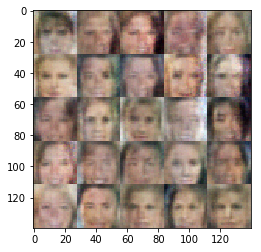

Epoch 1/1... Discriminator Loss: 0.3495... Generator Loss: 5.4198
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 6.9477
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 0.4030... Generator Loss: 6.4851
Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 2.7318
Epoch 1/1... Discriminator Loss: 0.3531... Generator Loss: 5.0567
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 6.9782
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 4.6399
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 3.5177
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 7.5436


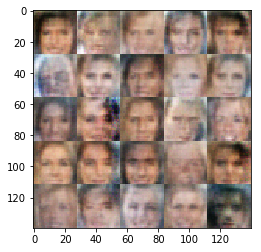

Epoch 1/1... Discriminator Loss: 1.9663... Generator Loss: 0.3598
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 3.9996
Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 2.9065
Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 3.1417
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 4.1395
Epoch 1/1... Discriminator Loss: 0.3404... Generator Loss: 7.5820
Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 5.3933
Epoch 1/1... Discriminator Loss: 0.3412... Generator Loss: 6.1010
Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 2.3144
Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 6.6028


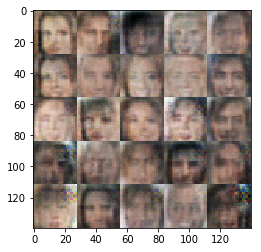

Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 5.3567
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 7.6083
Epoch 1/1... Discriminator Loss: 0.3426... Generator Loss: 7.8077
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 9.3809
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 3.5211
Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 2.2143
Epoch 1/1... Discriminator Loss: 0.3374... Generator Loss: 8.5099
Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 8.5950
Epoch 1/1... Discriminator Loss: 0.3500... Generator Loss: 8.4675
Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 1.4916


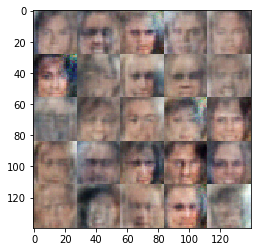

Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 9.9211
Epoch 1/1... Discriminator Loss: 0.3408... Generator Loss: 7.7254
Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 6.6108
Epoch 1/1... Discriminator Loss: 0.3509... Generator Loss: 6.4977
Epoch 1/1... Discriminator Loss: 0.3690... Generator Loss: 3.7904
Epoch 1/1... Discriminator Loss: 0.3381... Generator Loss: 7.7232
Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 6.5960
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 5.8299
Epoch 1/1... Discriminator Loss: 0.3955... Generator Loss: 3.4644
Epoch 1/1... Discriminator Loss: 0.4425... Generator Loss: 3.2707


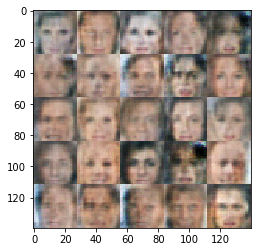

Epoch 1/1... Discriminator Loss: 0.4155... Generator Loss: 2.8731
Epoch 1/1... Discriminator Loss: 0.3482... Generator Loss: 6.5649
Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 4.8270
Epoch 1/1... Discriminator Loss: 0.3562... Generator Loss: 4.6059
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 4.8627
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 6.2549
Epoch 1/1... Discriminator Loss: 0.4022... Generator Loss: 2.8942
Epoch 1/1... Discriminator Loss: 0.3699... Generator Loss: 5.3392
Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 3.2530
Epoch 1/1... Discriminator Loss: 0.3394... Generator Loss: 9.7162


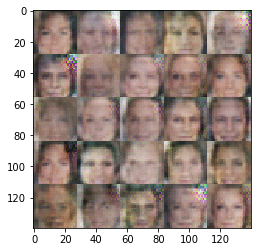

Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 5.2780
Epoch 1/1... Discriminator Loss: 0.3406... Generator Loss: 5.8460
Epoch 1/1... Discriminator Loss: 0.3426... Generator Loss: 8.7602
Epoch 1/1... Discriminator Loss: 0.3392... Generator Loss: 6.4599
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 5.7560
Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 2.1035
Epoch 1/1... Discriminator Loss: 0.3595... Generator Loss: 6.5477
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 2.4100


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.